<a href="https://colab.research.google.com/github/ElizavetaNosova/Ordering-text-quest-fragments/blob/main/BERT%2B_constrained_graph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from transformers import BertTokenizer, BertForNextSentencePrediction
from torch.utils.data import Dataset, DataLoader
import numpy as np

from sklearn.model_selection import train_test_split
from tqdm import tqdm
import os
import random
import math
import statistics

from networkx.readwrite import json_graph
import json

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
os.chdir('gdrive/MyDrive')

In [ ]:
tokenizer = BertTokenizer.from_pretrained('DeepPavlov/rubert-base-cased-sentence')

In [ ]:
bert_model = BertForNextSentencePrediction.from_pretrained('DeepPavlov/rubert-base-cased-sentence')

Some weights of BertForNextSentencePrediction were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased-sentence and are newly initialized: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
text1 = 'В лесу родилась елочка'
text2 = 'В лесу она росла'

In [ ]:
test

{'input_ids': tensor([[  101,   781, 25529, 16465, 31289, 16117,   102,   781, 25529,  4912,
         55349,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

In [ ]:
test.input_ids.shape[1]

12

In [ ]:
for key in test:
  test[key].cuda()

In [ ]:
outputs =  bert_model(**encoding, labels=torch.LongTensor([1]))
logits = outputs.logits

In [ ]:
test = bert_model.bert(tokenizer.encode('В лесу родилась елочка', return_tensors='pt'))

In [ ]:
test['pooler_output'].shape

torch.Size([1, 768])

In [ ]:
class 

In [ ]:
logits

tensor([[-0.0637,  0.0105]], grad_fn=<AddmmBackward>)

In [ ]:
torch.softmax(logits, 1)

tensor([[0.4815, 0.5185]], grad_fn=<SoftmaxBackward>)

In [ ]:
bert_model.train()
bert_model.cuda()
bert_model.bert.requires_grad_ = False
bert_model.cls.requires_grad_ = True

In [ ]:
optimizer = torch.optim.Adam([{'params': bert_model.cls.parameters()}],
                               lr = 1e-3)
criterion = torch.nn.BCELoss()

In [ ]:
batch_id = 0
for fragment1, fragment2, correct_label in tqdm(train_dataloader):
    encoding = tokenizer(fragment1, fragment2, return_tensors='pt', padding=True, truncation=False)
    encoding = {key:encoding[key].cuda() for key in encoding}
    try:
        outputs = bert_model(**encoding)
        prediction = torch.softmax(outputs.logits, 1)[:, 0]
        loss = criterion(prediction.cpu(), correct_label.float())
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        batch_id += 1
    except:
        pass
    if batch_id%100 == 0:
        torch.save(bert_model.cls.state_dict(), 'fixed_bert_next_sent_cls.state_dict.pth')


In [ ]:
bert_model.cls.load_state_dict(torch.load('fixed_bert_next_sent_cls.state_dict.pth'))

<All keys matched successfully>

In [ ]:
bert_model.cuda()

In [ ]:
bert_model.train()

In [ ]:
bert_model.eval()

correct = []
predicted = []

with torch.no_grad():
    for fragment1, fragment2, labels in tqdm(test_dataloader):
        encoding = tokenizer(fragment1, fragment2, return_tensors='pt', padding=True, truncation=False)
        outputs = bert_model(**encoding)
        prediction = torch.softmax(outputs.logits, 1)[:, 0]
        correct += [int(label) for label in labels]
        predicted += [float(p) for p in prediction]

 54%|█████▎    | 277/516 [1:06:55<2:21:22, 35.49s/it]

KeyboardInterrupt: ignored

In [ ]:
fpr_bert, tpr_bert, thresholds_bert = metrics.roc_curve(correct[:len(predicted)], predicted, pos_label=1)

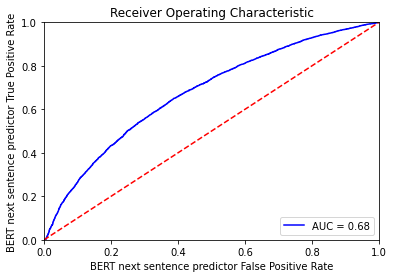

In [ ]:
from sklearn import metrics
fpr_bert, tpr_bert, thresholds_bert = metrics.roc_curve(correct[:len(predicted)], predicted, pos_label=1)
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
roc_ouc = metrics.auc(fpr_bert, tpr_bert)
plt.plot(fpr_bert, tpr_bert, 'b', label = 'AUC = %0.2f' % roc_ouc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('BERT next sentence predictor True Positive Rate')
plt.xlabel('BERT next sentence predictor False Positive Rate')
plt.show()

In [ ]:
outputs =  bert_model(**encoding)
logits = outputs.logits

In [ ]:
probs = torch.softmax(logits, 1)

In [ ]:
pred = probs[:, 0]

In [ ]:
torch.save(bert_model.cls.state_dict(), 'bert_next_sent_cls.state_dict.pth')

In [ ]:
label

tensor([0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1])

Beam search sequence generatin

Pairwise

In [ ]:
from copy import deepcopy

In [ ]:
class FragmentRepresentation:
    def __init__(self, fragment_text, fragment_idx=None):
        self.text = fragment_text
        self.fragment_idx = fragment_idx

In [ ]:
class FragmentsSequence:
    def __init__(self, initial_item:FragmentRepresentation):
        self.sequence = [initial_item]
        self.probability = 1

    def add_next_fragment(self, next_item:FragmentRepresentation, probability:float):
        self.sequence.append(next_item)
        self.probability *= probability

    def get_text_sequence(self):
        return [item.text for item in self.sequence]

    def get_idx_sequence(self):
        return [item.fragment_idx for item in self.sequence]

In [ ]:
def is_next_probability_probability_pairwise(previous_sequence:FragmentsSequence, next_fragment:FragmentRepresentation, use_gpu=True):
    last_sequence_item = previous_sequence.sequence[-1]
    encoding = tokenizer(last_sequence_item.text, next_fragment.text, return_tensors='pt', padding=True, truncation=False)
    if use_gpu:
        for key in encoding:
          encoding[key] = encoding[key].cuda()
    with torch.no_grad():
        outputs = bert_model(**encoding)
    probability = float(torch.softmax(outputs.logits, 1)[0, 0])
    return probability

In [ ]:
global_best_orders = 'dummy_variable_to_test'
def beam_search(first_fragment:FragmentRepresentation, next_fragments:set, num_best=3, scoring_function=is_next_probability_probability_pairwise, return_type='idx'):

    global global_best_orders   
  

    best_orders = [FragmentsSequence(first_fragment)]
    for i in range(len(next_fragments)):
        current_step_best_orders = []
        for order in best_orders:
            sequence_items_idxs = order.get_idx_sequence()
            possible_next_items = [item for item in next_fragments if item.fragment_idx not in sequence_items_idxs]
            scored_possible_next_items = [{'item':item, 'probability':scoring_function(order, item)} for item in possible_next_items]
            if len(scored_possible_next_items) <= num_best:
                best_next_items = scored_possible_next_items
            else: 
                best_next_items = sorted(scored_possible_next_items, key = lambda x: x['probability'], reverse=True)[:num_best]
            for item in best_next_items:
                order_copy = deepcopy(order)
                order_copy.add_next_fragment(item['item'], item['probability'])
                current_step_best_orders.append(order_copy)
                global_best_orders = best_orders
        best_orders = sorted(current_step_best_orders, key = lambda x: x.probability, reverse=True)
        if len(current_step_best_orders) > num_best:
            best_orders = best_orders[:num_best]
    best_order = best_orders[0]
    if return_type=='idx':
        return best_order.get_idx_sequence()
    elif retutn_type=='text':
        return best_order.get_text_sequence()

In [ ]:
results = []

PATHS_DIRECTORY = os.path.join('Quest_data', 'random_paths')
path_files = os.listdir(PATHS_DIRECTORY)
for test_graph_file in tqdm(test_online_graphs):
    if test_graph_file in path_files:
        with open(os.path.join(PATHS_DIRECTORY, test_graph_file), encoding='utf-8') as f:
            current_quest_paths = json.load(f)
        with open(os.path.join(ONLINE_GRAPHS_DIRECTORY, test_graph_file), encoding='utf-8') as f:
            G = json_graph.node_link_graph(json.load(f))
            nodes = G.nodes()

            for path in current_quest_paths:
                try:
                    real_path = [node_idx for node_idx in path if 'fragment_text' in nodes[node_idx] and isinstance(nodes[node_idx]['fragment_text'], str) and nodes[node_idx]['fragment_text'].strip()]
                    first_fragment = FragmentRepresentation(nodes[real_path[0]]['fragment_text'], real_path[0])
                    next_candidates = set([FragmentRepresentation(nodes[real_path[i]]['fragment_text'], real_path[i]) for i in range(1, len(real_path))])
                    prediction = beam_search(first_fragment, next_candidates)
                    results.append({'correct':real_path, 'predicted':prediction})
                except Exception as e:
                    print(e)

        with open('BERT_baseline_predictions.json', 'w', encoding='utf-8') as f:
            json.dump(results, f)
            


In [ ]:
with open('BERT_baseline_predictions.json', encoding='utf-8') as f:
    results = json.load(f)

In [ ]:
len(results)

1425

In [ ]:
results[0]

In [ ]:
from scipy import stats

In [ ]:
results[0]['correct'].index(results[0]['predicted'][0])

0

In [ ]:
for result in tqdm(results):
    #zero element was known, so we score ranks of other elements
    correct_ranks = list(range(1, len(result['correct'])))
    predicted_ranks = [result['correct'].index(i) for i in result['predicted'][1:]]
    tau, p_value = stats.kendalltau(correct_ranks, predicted_ranks)
    result['tau'] = tau
    result['p_value'] = p_value

100%|██████████| 1425/1425 [00:00<00:00, 2088.66it/s]


In [ ]:
import pandas as pd

In [ ]:
def get_correct_pairs_acc

In [ ]:
tau_df = pd.DataFrame({
    'num_candidates':[len(result['correct'])-1 for result in results],
    'tau': [result['tau'] for result in results],
    'correct_pairs_r': []
    })

In [ ]:
tau_df.describe()

,num_candidates,tau,p_value
count,1425.000000,1425.000000,1425.000000
mean,11.614737,-0.027728,0.481880
std,5.938678,0.353020,0.355001
min,2.000000,-1.000000,0.000083
25%,7.000000,-0.233333,0.128789
50%,11.000000,-0.047619,0.469444
75%,14.000000,0.200000,0.761150
max,35.000000,1.000000,1.250000


In [ ]:
tau_df.groupby('num_candidates').describe()

tau                      ...   p_value                    
                count      mean       std  ...       50%       75%       max
num_candidates                             ...                              
2                21.0 -0.809524  0.601585  ...  1.000000  1.000000  1.000000
3                39.0  0.094017  0.582135  ...  1.000000  1.000000  1.000000
4                73.0  0.200913  0.453858  ...  0.750000  0.750000  1.250000
5                85.0 -0.014118  0.341967  ...  0.816667  1.183333  1.183333
6                67.0  0.058706  0.350377  ...  0.719444  1.000000  1.000000
7                89.0 -0.026217  0.405272  ...  0.561905  0.772619  1.000000
8                74.0 -0.129344  0.325222  ...  0.398760  0.719544  1.095139
9               100.0 -0.141111  0.343868  ...  0.417598  0.649505  1.080545
10              107.0 -0.028037  0.286221  ...  0.600654  0.727490  1.000000
11              152.0 -0.045933  0.281321  ...  0.542259  0.761150  1.000000
12               99.0 -0.082032  0.295904  ...  0.380705  0.638361  1.053441
13              122.0 -0.084489  0.228811  ...  0.509775  0.675433  1.047638
14               62.0 -0.035094  0.296599  ...  0.330811  0.667174  1.000000
15               32.0  0.038095  0.345204  ...  0.092643  0.697181  0.922570
16               47.0  0.087234  0.332793  ...  0.165275  0.595067  1.035305
17               31.0  0.053605  0.347788  ...  0.076169  0.348846  0.967664
18               35.0 -0.096919  0.236644  ...  0.329674  0.600931  1.000000
19               25.0  0.066667  0.233455  ...  0.332007  0.628824  1.000000
20               29.0  0.080218  0.249422  ...  0.422250  0.677108  0.872841
21               28.0  0.173810  0.250084  ...  0.267491  0.457347  0.834682
22               20.0  0.123377  0.274206  ...  0.177968  0.503054  0.955577
23               17.0  0.130435  0.259985  ...  0.101926  0.373350  0.916847
24               14.0  0.076087  0.275403  ...  0.138891  0.722559  1.019567
25                6.0 -0.026667  0.172871  ...  0.228264  0.338460  0.694342
26               14.0 -0.116923  0.207550  ...  0.094093  0.234251  0.540831
27               11.0 -0.109557  0.222880  ...  0.134321  0.213203  0.362486
28                7.0 -0.214664  0.166810  ...  0.054742  0.085040  0.262789
29               14.0 -0.093244  0.242752  ...  0.071541  0.132346  0.896494
30                1.0  0.209195       NaN  ...  0.108774  0.108774  0.108774
31                1.0  0.023656       NaN  ...  0.866191  0.866191  0.866191
32                1.0  0.000000       NaN  ...  1.012829  1.012829  1.012829
34                1.0  0.048128       NaN  ...  0.688965  0.688965  0.688965
35                1.0  0.354622       NaN  ...  0.002731  0.002731  0.002731

[33 rows x 16 columns]

In [ ]:
import random
import statistics

In [ ]:
sequence_length2random_tau = {}
num_tests = 500
for seq_len in range(2, 30):
    current_taus = []
    correct = [i for i in range(seq_len)]
    for test in range(num_tests):
        shuffled = [i for i in range(seq_len)]
        random.shuffle(shuffled)
        tau, p_value = stats.kendalltau(correct, shuffled)
        current_taus.append(tau)
    sequence_length2random_tau [seq_len] = statistics.mean(current_taus)
sequence_length2random_tau

{2: 0.008,
 3: -0.010666666666666666,
 4: -0.007333333333333339,
 5: -0.010799999999999999,
 6: -0.016533333333333334,
 7: -0.030285714285714287,
 8: 0.0077142857142857135,
 9: -0.017444444444444443,
 10: 0.011999999999999999,
 11: 0.005163636363636363,
 12: 0.026,
 13: -0.01328205128205128,
 14: -0.0025494505494505493,
 15: 0.0028952380952380957,
 16: 0.0027666666666666664,
 17: -0.0015882352941176464,
 18: 0.0010718954248366012,
 19: 0.013450292397660818,
 20: -0.00728421052631579,
 21: -0.0025333333333333336,
 22: -0.004865800865800866,
 23: -0.009486166007905137,
 24: 0.0002608695652173911,
 25: -0.003746666666666666,
 26: -0.014855384615384616,
 27: 0.011202279202279205,
 28: 0.008952380952380953,
 29: -0.00817733990147783}

In [ ]:
stats.kendalltau([i for i in range(seq_len)], random.shuffle([i for i in range(seq_len)]))

#Fine tuning

In [ ]:
def encode_pair(text1, text2, tokenizer, limit=512, cuda=True):
    full_encoding = tokenizer(text1, text2, return_tensors='pt')
    if full_encoding.input_ids.shape[1] <= limit:
        encoding = full_encoding
    else:
        half_limit = limit//2-3
        #We encode texts, remove technical tokens [CLS] and [SEP] (first and last token), cut the sequence and encode a pair again
        short_version1 = tokenizer.decode(tokenizer.encode(text1)[1:-1][-half_limit:])
        short_version2 = tokenizer.decode(tokenizer.encode(text1)[1:-1][:half_limit])
        encoding = tokenizer(short_version1, short_version2, return_tensors='pt')
    if cuda:
        return {key:encoding[key].cuda() for key in encoding}
    else:
        return encoding

In [ ]:
bert_model.train()
bert_model.bert.requires_grad_ = True
bert_model.cls.requires_grad_ = True



optimizer = torch.optim.Adam([
                              {'params': bert_model.cls.parameters(), 'lr':1e-3},
                              {'params': bert_model.bert.parameters(), 'lr':1e-5},
                              ],)
criterion = torch.nn.BCELoss()

In [ ]:
encoding

{'input_ids': tensor([[101, 132, 102, 132, 102]]), 'token_type_ids': tensor([[0, 0, 0, 1, 1]]), 'attention_mask': tensor([[1, 1, 1, 1, 1]])}

In [ ]:
prediction

tensor([0.4378], device='cuda:0', grad_fn=<SelectBackward>)

In [ ]:
bert_model.train()
batch_id = 0
for epoch in range(3):
    for i in tqdm(range(len(train_dataset))):
        fragment1, fragment2, correct_label = train_dataset[i]
        encoding = encode_pair(fragment1, fragment2, tokenizer, cuda=True)
        try:
            outputs = bert_model(**encoding)
            prediction = torch.softmax(outputs.logits, 1)[:, 0]
            loss = criterion(prediction.float().cpu(), torch.tensor([correct_label]).float())
            loss.backward() 
            batch_id += 1
        except:
            pass
        if batch_id % 15 == 0:
            optimizer.step()
            optimizer.zero_grad()
        if batch_id%100 == 0:
            bert_model.save_pretrained('bert_next_sent_cls')

100%|██████████| 34570/34570 [52:47<00:00, 10.91it/s]


In [ ]:
bert_model = BertForNextSentencePrediction.from_pretrained('bert_next_sent_cls')

In [ ]:
bert_model.cuda()

In [ ]:
#fixed pipeline
bert_model.eval()

correct = []
predicted = []

with torch.no_grad():
    for fragment1, fragment2, labels in tqdm(test_dataloader):
        encoding = tokenizer(fragment1, fragment2, return_tensors='pt', padding=True, truncation=False)
        encoding = {key:encoding[key].cuda() for key in encoding}
        outputs = bert_model(**encoding)
        prediction = torch.softmax(outputs.logits, 1)[:, 0]
        correct += [int(label) for label in labels]
        predicted += [float(p) for p in prediction]

In [ ]:
from sklearn import metrics

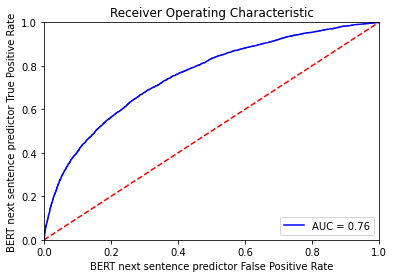

In [ ]:
from sklearn import metrics
fpr_bert, tpr_bert, thresholds_bert = metrics.roc_curve(correct, predicted, pos_label=1)
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
roc_ouc = metrics.auc(fpr_bert, tpr_bert)
plt.plot(fpr_bert, tpr_bert, 'b', label = 'AUC = %0.2f' % roc_ouc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('BERT next sentence predictor True Positive Rate')
plt.xlabel('BERT next sentence predictor False Positive Rate')
plt.show()

In [ ]:
test_encoding = encoding2cuda(tokenizer('e', 'f', return_tensors='pt'))

In [ ]:
float(torch.softmax(bert_model(**test_encoding)['logits'], 1)[0][0])

0.4026048481464386

In [ ]:
BERT_LIMIT = 512
BERT_HALF_LIMIT =  BERT_LIMIT // 2 - 3

def shorten_fragment(fragment, as_first=True):
    encoding = tokenizer.encode(fragment)
    if len(encoding) > BERT_HALF_LIMIT:
      meaningful_part = encoding[1:-1]
      shorten_part = meaningful_part[-BERT_HALF_LIMIT:] if as_first else meaningful_part[:BERT_HALF_LIMIT]
      fragment = tokenizer.decode(shorten_part)
    return fragment
    
def encoding2cuda(encoding):
    return {key:encoding[key].cuda() for key in encoding}

def bert_score(fragment1, fragment2):
    tokenizer_encoding = tokenizer(fragment1, fragment2, return_tensors='pt')
    if tokenizer_encoding['input_ids'].shape[1] > BERT_LIMIT:
        tokenizer_encoding = tokenizer(shorten_fragment(fragment1, as_first = True), shorten_fragment(fragment2, as_first = False), return_tensors='pt')
    encoding = encoding2cuda(tokenizer_encoding)
    return float(torch.softmax(bert_model(**encoding)['logits'], 1)[0][0])


In [ ]:
class Fragment:
    def __init__(self, fragment_id, nodes=None, text=None):
        self.fragment_id = fragment_id
        if nodes:
            self.text = nodes[fragment_id]['fragment_text']
        elif text:
            self.text = text

In [ ]:
pair_cash = {}
def bert_score_pair(fragment1, fragment2):
    text1 = fragment1.text
    text2 = fragment2.text
    if (text1, text2) in pair_cash:
        return pair_cash[(text1, text2)]
    else:
        tokenizer_encoding = tokenizer(text1, text2, return_tensors='pt')
        if tokenizer_encoding['input_ids'].shape[1] > BERT_LIMIT:
            tokenizer_encoding = tokenizer(shorten_fragment(text1, as_first = True), shorten_fragment(text2, as_first = False), return_tensors='pt')
        if torch.cuda.is_available():
            encoding = encoding2cuda(tokenizer_encoding)
        else:
            encoding = tokenizer_encoding
        outputs = bert_model(**encoding)
        score = float(outputs['logits'][0][0])
        pair_cash[(text1, text2)] = score
        return score

In [ ]:
def bert_beam_search(test_sample, quest_graph, num_best_candidates=2, text_key='fragment_text'):
    nodes = quest_graph.nodes()
    fragments = [Fragment(node_id, nodes) for node_id in test_sample]
    
    order_candidates = [{'beginning':[fragments[0]], 'next_candidates':copy(fragments[1:]), 'probability':1}]
    random.shuffle(order_candidates[0]['next_candidates'])
    
    for i in range(len(fragments)-1):
        current_iteration_next_candidates = []
        
        for order_candidate in order_candidates:
            last_fragment = order_candidate ['beginning'][-1]
            
            
            scored_next = [{'next_fragment':next_fragment, 'score':bert_score_pair(last_fragment, next_fragment)} for next_fragment in order_candidate['next_candidates']]
            scored_next.sort(key=lambda x: x['score'], reverse=True)
            
            chosen_next_candidates = scored_next[:num_best_candidates] if len(scored_next) < num_best_candidates else scored_next
            for chosen_next_candidate in chosen_next_candidates:
                next_fragment = chosen_next_candidate['next_fragment']
                
                next_step_beginning = copy(order_candidate['beginning'])
                next_step_beginning.append(next_fragment)
                
                next_step_probability = order_candidate['probability']*chosen_next_candidate['score']
                
                next_step_next_candidates = []
                for next_step_next_candidate in order_candidate['next_candidates']:
                    if next_step_next_candidate.fragment_id != next_fragment.fragment_id:
                        next_step_next_candidates.append(next_step_next_candidate)
                
              
                current_iteration_next_candidates.append({'beginning':next_step_beginning, 'next_candidates':next_step_next_candidates, 'probability':next_step_probability})
        
        current_iteration_next_candidates.sort(key=lambda x: x['probability'], reverse=True)
        order_candidates = current_iteration_next_candidates[:num_best_candidates] if len(current_iteration_next_candidates) > num_best_candidates else  current_iteration_next_candidates
    return [fragment.fragment_id for fragment in order_candidates[0]['beginning']]

In [ ]:
import math

In [ ]:
def scoring_bert_beam_search(test_sample, num_best_candidates=2, text_key='fragment_text', epsilon=10**(-9)):
    fragments = [Fragment(node_id, text=text) for node_id, text in enumerate(test_sample)]
    
    order_candidates = [{'beginning':[fragments[0]], 'next_candidates':copy(fragments[1:]), 'probability':0}]
    random.shuffle(order_candidates[0]['next_candidates'])
    
    for i in range(len(fragments)-1):
        current_iteration_next_candidates = []
        
        for order_candidate in order_candidates:
            last_fragment = order_candidate ['beginning'][-1]
            
            
            scored_next = [{'next_fragment':next_fragment, 'score':bert_score_pair(last_fragment, next_fragment)} for next_fragment in order_candidate['next_candidates']]
            scored_next.sort(key=lambda x: x['score'], reverse=True)
            
            chosen_next_candidates = scored_next[:num_best_candidates] if len(scored_next) < num_best_candidates else scored_next
            for chosen_next_candidate in chosen_next_candidates:
                next_fragment = chosen_next_candidate['next_fragment']
                
                next_step_beginning = copy(order_candidate['beginning'])
                next_step_beginning.append(next_fragment)
                
                score = chosen_next_candidate['score'] if chosen_next_candidate['score'] > 0 else epsilon
                next_step_probability = order_candidate['probability'] + math.log(score)
                
                next_step_next_candidates = []
                for next_step_next_candidate in order_candidate['next_candidates']:
                    if next_step_next_candidate.fragment_id != next_fragment.fragment_id:
                        next_step_next_candidates.append(next_step_next_candidate)
                
              
                current_iteration_next_candidates.append({'beginning':next_step_beginning, 'next_candidates':next_step_next_candidates, 'probability':next_step_probability})
        
        current_iteration_next_candidates.sort(key=lambda x: x['probability'], reverse=True)
        order_candidates = current_iteration_next_candidates[:num_best_candidates] if len(current_iteration_next_candidates) > num_best_candidates else  current_iteration_next_candidates
    return {'order': [fragment.fragment_id for fragment in order_candidates[0]['beginning']], 'score': order_candidates[0]['probability']}

In [ ]:
with open('sanity_check_data.json') as f:
  sanity_check_data = json.load(f)

In [ ]:
sanity_check_data.keys()

dict_keys(['real', 'random'])

In [ ]:
from copy import copy

In [ ]:
real_predictions = [scoring_bert_beam_search(path) for path in sanity_check_data['real']]
random_predictions = [scoring_bert_beam_search(path) for path in sanity_check_data['random']]

In [ ]:
real_predictions

[{'order': [0, 2, 4, 5, 3, 8, 7, 6, 1], 'score': -87.73243285927907},
 {'order': [0, 2, 1, 3], 'score': -27.053669855249773},
 {'order': [0, 2, 1, 4, 14, 3, 10, 8, 16, 11, 17, 5, 15, 9, 6, 7, 12, 13],
  'score': -81.3190528865455},
 {'order': [0, 3, 5, 9, 4, 8, 6, 7, 2, 1], 'score': -72.31592877791346},
 {'order': [0, 15, 17, 7, 5, 3, 4, 6, 14, 8, 9, 11, 13, 12, 16, 18, 10, 1, 2],
  'score': -40.078966518653225}]

In [ ]:
from statistics import mean

In [ ]:
mean([sample['score'] for sample in real_predictions])

-61.700010179528206

In [ ]:
mean([sample['score'] for sample in random_predictions])

-193.81721110523338

In [ ]:
TEST_PATH_DIRECTORY = 'tokenized_ordering_test_joined'

In [ ]:
from copy import copy

In [ ]:
result = []
fails = []

for file in tqdm(os.listdir(TEST_PATH_DIRECTORY)[928:]):
    try:
        with open(os.path.join(TEST_PATH_DIRECTORY, file)) as f:
            _, path, graph_json, __ = json.load(f)
        
        graph = json_graph.node_link_graph(graph_json)
        prediction = bert_beam_search(copy(path), graph)
        result.append({'correct':path, 'predicted':prediction})
    except Exception as e:
        fails.append([file, e])
    if len (result) % 100 == 0:
        with open('finetuned_bert_beam_search_result.json', 'w') as f:
            json.dump(result, f)

with open('finetuned_bert_beam_search_result.json', 'w') as f:
    json.dump(result, f)

100%|██████████| 2502/2502 [1:02:29<00:00,  1.50s/it]


In [ ]:
with open('finetuned_bert_beam_search_result.json', encoding='utf-8') as f:
    result = json.load(f)

In [ ]:
len(results)

2422

In [ ]:
from scipy.stats import kendalltau

def longest_correct_subsequence(predicted, correct):
    correct_transitions = set([(item_from, item_to) for item_from, item_to in zip(correct[:-1], correct[1:])])
    predicted_transitions = [(item_from, item_to) for item_from, item_to in zip(predicted[:-1], predicted[1:])]
    predicted_transitions_are_correct = [transition in correct_transitions for transition in predicted_transitions]
    
    longest_correct_transitions_subsequence = 0
    current_correct_transitions_subsequence = 0
    #Add False as last item to include last real item checking into the loop
    for predicted_transition_is_correct in predicted_transitions_are_correct + [False]:
        if predicted_transition_is_correct:
            current_correct_transitions_subsequence += 1
        else:
            if current_correct_transitions_subsequence > longest_correct_transitions_subsequence:
                longest_correct_transitions_subsequence = current_correct_transitions_subsequence
            current_correct_transitions_subsequence = 0
    #return number of items in longest correct sequence (not number of transitions)
    return longest_correct_transitions_subsequence + 1 if longest_correct_transitions_subsequence else 0  

In [ ]:
import pandas as pd

In [ ]:
finetuned_bert_df = pd.DataFrame(columns = ["sequence length", "Kendall's  tau", "Longest correct subsequence"])
for sequence_data in result:
    predicted = sequence_data['predicted']
    correct = sequence_data['correct']
    tau = kendalltau(predicted[1:], correct[1:]).correlation
    lcs = longest_correct_subsequence(predicted, correct)
    finetuned_bert_df.loc[len(finetuned_bert_df)] = [len(correct), tau, lcs]
    

In [ ]:
finetuned_bert_df_aggr = finetuned_bert_df[finetuned_bert_df["sequence length"]<=30].groupby("sequence length").describe()[[("Kendall's  tau", 'count'),  ("Kendall's  tau",  'mean'), ('Longest correct subsequence',  'mean')]]
finetuned_bert_df_aggr

Kendall's  tau           Longest correct subsequence
                         count      mean                        mean
sequence length                                                     
4.0                       81.0 -0.028807                    1.802469
5.0                       73.0  0.159817                    1.575342
6.0                      109.0 -0.011009                    1.256881
7.0                       88.0 -0.037879                    1.693182
8.0                       79.0  0.098252                    1.911392
9.0                      152.0  0.002820                    1.592105
10.0                     131.0 -0.022901                    1.572519
11.0                     207.0 -0.003113                    1.584541
12.0                     195.0  0.003636                    1.702564
13.0                     101.0  0.008701                    1.841584
14.0                     106.0 -0.008466                    1.726415
15.0                      73.0  0.026946                    1.753425
16.0                      75.0  0.013587                    1.680000
17.0                      57.0 -0.023684                    1.631579
18.0                      64.0  0.013557                    1.515625
19.0                      57.0  0.014563                    1.543860
20.0                      44.0  0.010633                    2.090909
21.0                      38.0  0.022992                    1.868421
22.0                      51.0 -0.042764                    1.745098
23.0                      41.0  0.022490                    1.682927
24.0                      47.0 -0.052729                    1.574468
25.0                      46.0 -0.034814                    1.630435
26.0                      21.0 -0.030794                    1.809524
27.0                      43.0 -0.022111                    1.883721
28.0                      25.0 -0.006040                    1.720000
29.0                      29.0  0.037584                    1.517241
30.0                      24.0  0.008210                    1.708333

In [ ]:
with open('finetuned_bert_df_aggr.txt', 'w') as f:
  f.write(finetuned_bert_df_aggr.to_latex())

In [ ]:
fails

NameError: ignored

In [ ]:
class MLPPairBinaryClassifier(torch.nn.Module):
  def __init__(self, input_dim=768, hidden_dim_1=100, hidden_dim_2=50, bias=False, dropout=0.05):
      super().__init__()
      self.dropout = torch.nn.Dropout(dropout)
      self.linear1 = torch.nn.Linear(input_dim*2, hidden_dim_1, bias=bias)
      self.linear2 = torch.nn.Linear(hidden_dim_1, hidden_dim_2, bias=bias)
      self.classifier = torch.nn.Linear(hidden_dim_2, 1)

  def forward(self, embedding1, embedding2):
      concat_embedding = torch.cat((embedding1, embedding2), -1)
      concat_embedding = self.dropout(torch.tanh(self.linear1(concat_embedding)))
      concat_embedding = self.dropout(torch.tanh(self.linear2(concat_embedding)))
      return torch.sigmoid(self.classifier(concat_embedding))


In [ ]:
class MLPPairBinaryClassifier_v2(torch.nn.Module):
    def __init__(self, input_dim=768, hidden_dim_1=100, hidden_dim_2=50, bias=False, dropout=0.05):
        super().__init__()
        self.dropout = torch.nn.Dropout(dropout)
        self.linear1 = torch.nn.Linear(input_dim*2, hidden_dim_1, bias=bias)
        self.linear2 = torch.nn.Linear(hidden_dim_1, hidden_dim_2, bias=bias)
        self.classifier = torch.nn.Linear(hidden_dim_2, 2)

    def forward(self, embedding1, embedding2):
      concat_embedding = torch.cat((embedding1, embedding2), -1)
      concat_embedding = self.dropout(torch.tanh(self.linear1(concat_embedding)))
      concat_embedding = self.dropout(torch.tanh(self.linear2(concat_embedding)))
      return torch.softmax(self.classifier(concat_embedding), 1)[:,0]

In [ ]:
MLPclassifier4graph = MLPPairBinaryClassifier_v2()

In [ ]:
MLPclassifier4graph(torch.ones(768,1).t(), torch.ones(768, 1).t())

tensor([0.5453], grad_fn=<SelectBackward>)

In [ ]:
def encoding2cuda(encoding, truncation=None, max_length=512):
    encoding = {key: encoding[key].cuda() for key in encoding}
    if encoding['input_ids'].shape[1] > max_length:
        if truncation == 'l':
            encoding = {key: encoding[key][:, -max_length:].clone() for key in encoding}
        elif truncation == 'r':
             encoding = {key: encoding[key][:, :max_length].clone() for key in encoding}
    return encoding
        

In [ ]:
encoding2.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [ ]:
[encoding2[key].shape for key in encoding2]

[torch.Size([1, 512]), torch.Size([1, 512]), torch.Size([1, 512])]

In [ ]:
mlp_classifier = MLPPairBinaryClassifier()
mlp_optimizer =  torch.optim.Adam([{'params': mlp_classifier.parameters()}], 
                              lr = 1e-3)
criterion = torch.nn.BCELoss()

In [ ]:
encoding1

{'input_ids': [101, 132, 102], 'token_type_ids': [0, 0, 0], 'attention_mask': [1, 1, 1]}

In [ ]:
import transformers

In [ ]:
mlp_classifier.cuda()

MLPPairBinaryClassifier(
  (dropout): Dropout(p=0.05, inplace=False)
  (linear1): Linear(in_features=1536, out_features=100, bias=False)
  (linear2): Linear(in_features=100, out_features=50, bias=False)
  (classifier): Linear(in_features=50, out_features=1, bias=True)
)

In [ ]:
mlp_classifier.train()

MLPPairBinaryClassifier(
  (dropout): Dropout(p=0.05, inplace=False)
  (linear1): Linear(in_features=1536, out_features=100, bias=False)
  (linear2): Linear(in_features=100, out_features=50, bias=False)
  (classifier): Linear(in_features=50, out_features=1, bias=True)
)

In [ ]:
bert_limit=512
for epoch in range(3):
    for i in range(len(train_dataset)):
        fragment1, fragment2, correct_label = train_dataset[i]
        encoding1 = tokenizer(fragment1, return_tensors='pt')
        encoding2 = tokenizer(fragment2, return_tensors='pt')
        representation1 = bert_model.bert(encoding2cuda(encoding1, truncation='l')['input_ids'])['pooler_output']
        representation2 = bert_model.bert(encoding2cuda(encoding2, truncation='r')['input_ids'])['pooler_output']
        probs = mlp_classifier(representation1, representation2) 

        loss = criterion(torch.squeeze(probs).cpu(), torch.squeeze(torch.tensor([correct_label])).float())
        loss.backward() 
        if i % 50 == 0:
            mlp_optimizer.step()
            mlp_optimizer.zero_grad()
        if i % 1500 == 0:
            torch.save(mlp_classifier.state_dict(), 'mlp_classifier_initial.pth')
            print(i/len(train_dataset))

0.0
0.04339022273647671


KeyboardInterrupt: ignored

In [ ]:
mlp_classifier.load_state_dict(torch.load('mlp_classifier_initial.pth', map_location=torch.device('cpu')))

<All keys matched successfully>

In [ ]:
mlp_classifier.cuda()

MLPPairBinaryClassifier(
  (dropout): Dropout(p=0.05, inplace=False)
  (linear1): Linear(in_features=1536, out_features=100, bias=False)
  (linear2): Linear(in_features=100, out_features=50, bias=False)
  (classifier): Linear(in_features=50, out_features=1, bias=True)
)

In [ ]:
bert_model.eval()
mlp_classifier.eval()

correct = []
predicted = []

with torch.no_grad():
    for fragment1, fragment2, label in test_dataset:
        encoding1 = tokenizer(fragment1, return_tensors='pt')
        encoding2 = tokenizer(fragment2, return_tensors='pt')
        representation1 = bert_model.bert(encoding2cuda(encoding1, truncation='l')['input_ids'])['pooler_output']
        representation2 = bert_model.bert(encoding2cuda(encoding2, truncation='r')['input_ids'])['pooler_output']
        prob = mlp_classifier(representation1, representation2) 

        correct += [label]
        predicted += [float(prob)]

In [ ]:
len(predicted)

19210

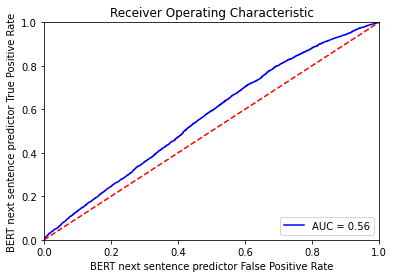

In [ ]:
from sklearn import metrics
fpr_bert, tpr_bert, thresholds_bert = metrics.roc_curve(correct, predicted, pos_label=1)
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
roc_ouc = metrics.auc(fpr_bert, tpr_bert)
plt.plot(fpr_bert, tpr_bert, 'b', label = 'AUC = %0.2f' % roc_ouc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('BERT next sentence predictor True Positive Rate')
plt.xlabel('BERT next sentence predictor False Positive Rate')
plt.show()

In [ ]:
torch.save(mlp_classifier, 'mlp_classifier_initial.pth')

In [ ]:
probs

tensor([0.2728], device='cuda:0', grad_fn=<SelectBackward>)

In [ ]:
embedding1

NameError: ignored

In [ ]:
text = 'кошка ' * 1000

In [ ]:
res = bert_model.bert(test['input_ids'])

In [ ]:
res['last_hidden_state'].shape

torch.Size([1, 512, 768])

In [ ]:
res['pooler_output'].shape

torch.Size([1, 768])

In [ ]:
res

In [ ]:
encoding2 = tokenizer(text, return_tensors='pt')

In [ ]:
encoding2['input_ids'].shape

torch.Size([1, 1002])

In [ ]:
test = encoding2cuda(encoding2, truncation='l')

In [ ]:
test['input_ids'].shape

torch.Size([1, 512])

In [ ]:
bert_model = BertForNextSentencePrediction.from_pretrained('DeepPavlov/rubert-base-cased-sentence')

In [ ]:
mlp_classifier = MLPPairBinaryClassifier()
#mlp_optimizer =  torch.optim.Adam([{'params': mlp_classifier.parameters()}], 
#                               lr = 1e-3)
#criterion = torch.nn.BCELoss()


NameError: ignored

In [ ]:
bert_model.cuda()
mlp_classifier.cuda()

NameError: ignored

In [ ]:
bert_limit=512
for epoch in range(1):
    for i in range(len(train_dataset)):
        fragment1, fragment2, correct_label = train_dataset[i]
        encoding1 = tokenizer(fragment1, return_tensors='pt')
        encoding2 = tokenizer(fragment2, return_tensors='pt')
        representation1 = bert_model.bert(encoding2cuda(encoding1, truncation='l')['input_ids'])['pooler_output']
        representation2 = bert_model.bert(encoding2cuda(encoding2, truncation='r')['input_ids'])['pooler_output']
        probs = mlp_classifier(representation1, representation2) 

        loss = criterion(torch.squeeze(probs).cpu(), torch.squeeze(torch.tensor([correct_label])).float())
        loss.backward() 
        if i % 50 == 0:
            mlp_optimizer.step()
            mlp_optimizer.zero_grad()
        if i % 1500 == 0:
            torch.save(mlp_classifier.state_dict(), 'mlp_classifier_initial.pth')
            print(i/len(train_dataset))

0.0
0.04339022273647671
0.08678044547295342
0.13017066820943013
0.17356089094590685
0.21695111368238357
0.26034133641886026
0.303731559155337
0.3471217818918137
0.39051200462829044
0.43390222736476713
0.4772924501012438
0.5206826728377205
0.5640728955741973
0.607463118310674
0.6508533410471508
0.6942435637836274
0.7376337865201041
0.7810240092565809
0.8244142319930575
0.8678044547295343
0.911194677466011
0.9545849002024877
0.9979751229389644


In [ ]:
bert_model.eval()
mlp_classifier.eval()

correct = []
predicted = []

with torch.no_grad():
    for fragment1, fragment2, label in test_dataset:
        encoding1 = tokenizer(fragment1, return_tensors='pt')
        encoding2 = tokenizer(fragment2, return_tensors='pt')
        representation1 = bert_model.bert(encoding2cuda(encoding1, truncation='l')['input_ids'])['pooler_output']
        representation2 = bert_model.bert(encoding2cuda(encoding2, truncation='r')['input_ids'])['pooler_output']
        prob = mlp_classifier(representation1, representation2) 

        correct += [label]
        predicted += [float(prob)]

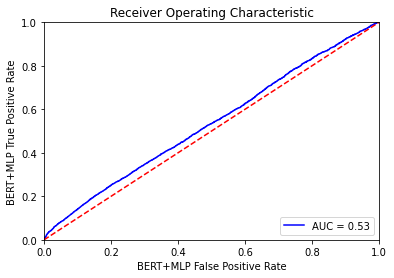

In [ ]:
from sklearn import metrics
fpr_bert, tpr_bert, thresholds_bert = metrics.roc_curve(correct, predicted, pos_label=1)
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
roc_ouc = metrics.auc(fpr_bert, tpr_bert)
plt.plot(fpr_bert, tpr_bert, 'b', label = 'AUC = %0.2f' % roc_ouc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('BERT+MLP True Positive Rate')
plt.xlabel('BERT+MLP False Positive Rate')
plt.show()

In [ ]:
optimizer =  torch.optim.Adam([{'params': mlp_classifier.parameters(), 'lr':1e-3}, {'params': bert_model.bert.parameters(), 'lr':1e-5}])

In [ ]:
bert_limit=512
for epoch in range(2):
    for i in range(len(train_dataset)):
        fragment1, fragment2, correct_label = train_dataset[i]
        encoding1 = tokenizer(fragment1, return_tensors='pt')
        encoding2 = tokenizer(fragment2, return_tensors='pt')
        representation1 = bert_model.bert(encoding2cuda(encoding1, truncation='l')['input_ids'])['pooler_output']
        representation2 = bert_model.bert(encoding2cuda(encoding2, truncation='r')['input_ids'])['pooler_output']
        probs = mlp_classifier(representation1, representation2) 

        loss = criterion(torch.squeeze(probs).cpu(), torch.squeeze(torch.tensor([correct_label])).float())
        loss.backward() 
        if i % 50 == 0:
            optimizer.step()
            optimizer.zero_grad()
        if i % 1500 == 0:
            torch.save(mlp_classifier.state_dict(), 'mlp_classifier_initial.pth')
            bert_model.save_pretrained('bert4mlp')
            print(i/len(train_dataset))

In [ ]:
bert_model.eval()
mlp_classifier.eval()

correct = []
predicted = []

with torch.no_grad():
    for fragment1, fragment2, label in test_dataset:
        encoding1 = tokenizer(fragment1, return_tensors='pt')
        encoding2 = tokenizer(fragment2, return_tensors='pt')
        representation1 = bert_model.bert(encoding2cuda(encoding1, truncation='l')['input_ids'])['pooler_output']
        representation2 = bert_model.bert(encoding2cuda(encoding2, truncation='r')['input_ids'])['pooler_output']
        prob = mlp_classifier(representation1, representation2) 

        correct += [label]
        predicted += [float(prob)]

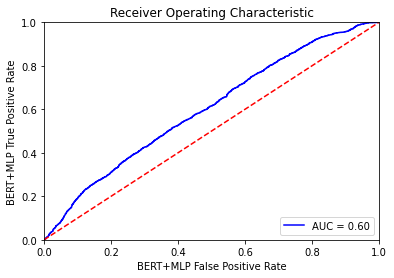

In [ ]:
from sklearn import metrics
fpr_bert, tpr_bert, thresholds_bert = metrics.roc_curve(correct, predicted, pos_label=1)
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
roc_ouc = metrics.auc(fpr_bert, tpr_bert)
plt.plot(fpr_bert, tpr_bert, 'b', label = 'AUC = %0.2f' % roc_ouc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('BERT+MLP True Positive Rate')
plt.xlabel('BERT+MLP False Positive Rate')
plt.show()

In [ ]:
bert_model = BertForNextSentencePrediction.from_pretrained('bert4mlp')

In [ ]:
bert_model.cuda()

In [ ]:
def bert_encode_fragment(text, tokenizer, bert):
    bert_limit = 512
    encoding = tokenizer(text, return_tensors='pt')['input_ids'].to(bert.device)
    if encoding.shape[1] <= bert_limit:
        return bert(encoding)['pooler_output']
    else:
       encoding_as_first = encoding[:, -bert_limit:]
       encoding_as_second = encoding[:, :bert_limit]
       return (bert(encoding_as_first)['pooler_output']+bert(encoding_as_second)['pooler_output'])/2

In [ ]:
test = 'кошка '*1000

In [ ]:
bert

In [ ]:
tokenizer(test, return_tensors='pt')['input_ids'].shape

torch.Size([1, 1002])

In [ ]:
with open(os.path.join(BOOK_GRAPHS_DIRECTORY, os.listdir(BOOK_GRAPHS_DIRECTORY)[0]), encoding='utf-8') as f:
    encoding = tokenizer(text, return_tensors='pt')['input_ids'].cuda()
    if encoding.shape[1] <= 512:
        

In [ ]:
bert_model.cuda()

NameError: ignored

In [ ]:
test

In [ ]:
def get_bert_encoding_json(encoding, bert):
    return [float(i) for i in torch.squeeze(bert(encoding)['pooler_output'])]

In [ ]:
node.keys()

dict_keys(['fragment_text', 'id', 'bert_encoding'])

In [ ]:
bert_limit=512
for file_name in tqdm(os.listdir(ONLINE_GRAPHS_DIRECTORY)):
    book_path = os.path.join(ONLINE_GRAPHS_DIRECTORY, file_name)
    with open(book_path, encoding='utf-8') as f:
        data = json.load(f)
        for node in data['nodes']:
            if 'fragment_text' in node and isinstance(node['fragment_text'], str):
                fragment_text = node['fragment_text']
                encoding = tokenizer(fragment_text, return_tensors='pt')['input_ids'].cuda()
                del node['bert_encoding']
                if encoding.shape[1] <= bert_limit:
                    node['bert_encoding'] = get_bert_encoding_json(encoding, bert_model.bert)
                else:
                    encoding_as_first = encoding[:, -bert_limit:]
                    encoding_as_second = encoding[:, :bert_limit]
                    node['bert_encoding_as_first'] =  get_bert_encoding_json(encoding_as_first, bert_model.bert)
                    node['bert_encoding_as_second'] =  get_bert_encoding_json(encoding_as_second, bert_model.bert)
    with open(book_path, 'w', encoding='utf-8') as f:
        json.dump(data, f)

In [ ]:
for file_name in tqdm(os.listdir(BOOK_GRAPHS_DIRECTORY)):
    book_path = os.path.join(BOOK_GRAPHS_DIRECTORY, file_name)
    with open(book_path, encoding='utf-8') as f:
        data = json.load(f)
        for node in data['nodes']:
            if 'fragment_text' in node and isinstance(node['fragment_text'], str):
                fragment_text = node['fragment_text']
                encoding = tokenizer(fragment_text, return_tensors='pt')['input_ids'].cuda()
                if encoding.shape[1] <= bert_limit:
                    node['bert_encoding'] = get_bert_encoding_json(encoding, bert_model.bert)
                else:
                    encoding_as_first = encoding[:, -bert_limit:]
                    encoding_as_second = encoding[:, :bert_limit]
                    node['bert_encoding_as_first'] =  get_bert_encoding_json(encoding_as_first, bert_model.bert)
                    node['bert_encoding_as_second'] =  get_bert_encoding_json(encoding_as_second, bert_model.bert)
    with open(book_path, 'w', encoding='utf-8') as f:
        json.dump(data, f)

In [ ]:
BOOK_GRAPHS_DIRECTORY

'Quest_data/questbook_graphs'

In [ ]:
test['nodes'][0].keys()

dict_keys(['fragment_text', 'id'])

In [ ]:
class GraphBasedOrderingNetwork(torch.nn.Module):
    def __init__(self, pretrained_MLP, num_iterations, initial_self_coef, update_previous=False, threshold = 0.5, joined_key='bert_encoding', first_key='bert_encoding_as_first', second_key='bert_encoding_as_second'):
        super().__init__()
        self.mlp = pretrained_MLP
        self.num_iterations = num_iterations
        self.self_coef = torch.nn.Linear(1,1, bias=False)
        self.self_coef.weight = torch.nn.Parameter(torch.tensor([[initial_self_coef]]).float())
        self.neighbour_coef = torch.nn.Linear(1,1, bias=False)
        self.neighbour_coef.weight = torch.nn.Parameter(torch.tensor([[1]]).float())
        self.direction = 'previous' if update_previous else 'next'

        self.first_key = first_key
        self.second_key = second_key
        self.joined_key = joined_key
        self.threshold = threshold

    def forward(self, graph=None, path=None, texts=None):
        if graph and path:
            joined_representations, first_representations, second_representations = self.get_initial_representations(graph, path)
        else:
            joined_representations, first_representations, second_representations = self.get_initial_representations4texts(texts)
        probabilities = self.calc_probabilities(first_representations, second_representations )
        for iteration in range(self.num_iterations):
            joined_representations = self.update_representations(joined_representations,  probabilities)
            probabilities  = self.calc_probabilities(joined_representations, joined_representations)
        return probabilities
            


    def get_initial_representations(self, graph, path):
        nodes = graph.nodes()

        path_representations_as_first = []
        path_representation_as_second = []

        path_representations_joined = []
        for node in path:
            if self.joined_key in nodes[node]:
               for representations in  path_representations_joined, path_representations_as_first, path_representation_as_second:
                   representations.append(torch.tensor(nodes[node][self.joined_key]))
            elif self.first_key in nodes[node] and self.second_key in nodes[node]:
                encoding_as_first = torch.tensor(nodes[node][self.first_key])
                encoding_as_second =  torch.tensor(nodes[node][self.second_key])
                path_representations_as_first.append(encoding_as_first)
                path_representation_as_second.append(encoding_as_second)
                path_representations_joined.append(0.5*encoding_as_first+0.5*encoding_as_second)
            else:
                raise ValueError('Graph should contain bert encoding of texts')
        return self.cat_representations(path_representations_joined).t(),  self.cat_representations(path_representations_as_first).t(), self.cat_representations(path_representation_as_second).t()

    def get_initial_representations4texts(self, texts):

        path_representations_as_first = []
        path_representation_as_second = []

        path_representations_joined = []

        for text in texts:
            encoding = tokenizer(text, return_tensors='pt')['input_ids']
            if encoding.shape[1] <= bert_limit:
                bert_encoding = get_bert_encoding_json(encoding, bert_model.bert)
                for representations in  path_representations_joined, path_representations_as_first, path_representation_as_second:
                    representations.append(bert_encoding)

            else:
                encoding_as_first = encoding[:, -bert_limit:]
                encoding_as_second = encoding[:, :bert_limit]
                path_representations_as_first.append(encoding_as_first)
                path_representation_as_second.append(encoding_as_second)
                path_representations_joined.append(0.5*encoding_as_first+0.5*encoding_as_second)
        return self.cat_representations(path_representations_joined).t(),  self.cat_representations(path_representations_as_first).t(), self.cat_representations(path_representation_as_second).t()

    
    
    
    def cat_representations(self, representations):
        print(representations)
        return torch.cat([torch.unsqueeze(torch.tensor(tensor), 1) for tensor in representations], 1)

    def calc_probabilities(self, first_representations, second_representations):
        assert first_representations.shape == second_representations.shape
        num_fragments = first_representations.shape[0]
        probabilities = torch.zeros(num_fragments, num_fragments)
        for i, first_representation in enumerate(first_representations):
            for j, second_representation in enumerate(second_representations):
                if i != j:
                    probabilities[i][j] = torch.squeeze(self.mlp(torch.unsqueeze(first_representation, 0), torch.unsqueeze(second_representation, 0)))
        return probabilities

    
    def update_representations(self, representations, probabilities):
        unsqueezed_representations = torch.unsqueeze(representations, 2)
        new_representations =  unsqueezed_representations.clone()
        new_representatios = self.self_coef(new_representations)

        for i, probability_vector in enumerate(probabilities):
            for j, probability in enumerate(probability_vector):
                if probability >= self.threshold:
                    if self.direction == 'next':
                        new_representations[j] = new_representations[j].clone() + probability*self.neighbour_coef(unsqueezed_representations[i]).clone()
                    else:
                        new_representations[i] = new_representations[i].clone() + self.neighbour_coef(unsqueezed_representationss[j]).clone()
        return torch.squeeze(new_representations)

In [ ]:
pretrained_MLP = MLPPairBinaryClassifier()
pretrained_MLP.load_state_dict(torch.load('mlp_classifier_initial.pth', map_location=torch.device('cpu')))

<All keys matched successfully>

In [ ]:
MLPclassifier4graph = MLPPairBinaryClassifier_v2()

In [ ]:
MLPclassifier4graph

In [ ]:
MLPclassifier4graph.linear1 = pretrained_MLP.linear1
MLPclassifier4graph.linear2 = pretrained_MLP.linear2

In [ ]:
model = GraphBasedOrderingNetwork(MLPclassifier4graph, num_iterations=1, initial_self_coef=1, threshold=0.1)

In [ ]:
optimizer = torch.optim.Adam([{'params': model.parameters()}], 
                               lr = 1e-3)
criterion = torch.nn.BCELoss()

In [ ]:
BOOK_PATHS_DIRECTORY = os.path.join('Quest_data', 'book_paths')
ONLINE_PATHS_DIRECTORY = os.path.join('Quest_data', 'random_paths')


In [ ]:

dev_online_paths, test_online_paths = train_test_split(os.listdir(ONLINE_PATHS_DIRECTORY), random_state=42, test_size=0.4)

all_dev_paths = [('book', book_paths_file) for book_paths_file in os.listdir(BOOK_PATHS_DIRECTORY)] + [('online', online_paths_file) for online_paths_file in dev_online_paths]

train_paths, valid_paths = train_test_split(all_dev_paths, random_state=42, test_size=0.1)

In [ ]:
def correct_path(path, graph, text_key):
    nodes = G.nodes()
    return [node_id for node_id in path if text_key in nodes[node_id] and isinstance(nodes[node_id][text_key], str)]

In [ ]:
model.training

True

In [ ]:
num_samples = 0
for quest_type, file_name in tqdm(train_paths[3:]):
    text_key = 'fragment_text'
    try:
        if quest_type == 'book':
            paths_directory = BOOK_PATHS_DIRECTORY
            quests_directory = BOOK_GRAPHS_DIRECTORY
        else:
            paths_directory = ONLINE_PATHS_DIRECTORY
            quests_directory = ONLINE_GRAPHS_DIRECTORY

        with open(os.path.join(paths_directory, file_name), encoding='utf-8') as f:
            paths = json.load(f)

        with open(os.path.join(quests_directory,  file_name), encoding='utf-8') as f:
            G = json_graph.node_link_graph(json.load(f))
        
        for path in paths:
            corrected_path = correct_path(path, G, text_key)
            if len(corrected_path) > 3:
                predicted = model(G, corrected_path)[1:, :-1].clone().cpu()
                correct = torch.eye(predicted.shape[0])
                loss = criterion(predicted, correct)
                loss.backward()
                num_samples += 1
                if num_samples % 10 == 0:
                    optimizer.step()
                    optimizer.zero_grad()
                if num_samples % 200 == 0:
                    torch.save(model.state_dict(), 'construted_graph_model.pth')
    #if some graph files are deleted, but random paths exist
    except FileNotFoundError:
        pass

In [ ]:
model.load_state_dict(torch.load('construted_graph_model.pth'))

<All keys matched successfully>

In [ ]:
predictions = []
num_samples = 0
for file_name in tqdm(test_online_paths):
    try:
        paths_directory = ONLINE_PATHS_DIRECTORY
        quests_directory = ONLINE_GRAPHS_DIRECTORY
        text_key = 'fragment_text'

        with open(os.path.join(paths_directory, file_name), encoding='utf-8') as f:
            paths = json.load(f)

        with open(os.path.join(quests_directory,  file_name), encoding='utf-8') as f:
            G = json_graph.node_link_graph(json.load(f))


        with torch.no_grad(): 
            for path in paths:
                corrected_path = correct_path(path, G, text_key)
                if len(corrected_path) > 3:
                    predicted = model(G, corrected_path).tolist()
                    predictions.append(predicted)
                    num_samples += 1
                if num_samples % 200 == 0:
                    with open('BERT_graph_predictions.json', 'w', encoding = 'utf-8') as f:
                        json.dump(predictions, f)
    #if some graph files are deleted, but random paths exist
    except FileNotFoundError:
        pass


100%|██████████| 76/76 [59:07<00:00, 46.68s/it]


In [ ]:
with open('BERT_graph_predictions.json') as f:
    predictions = json.load(f)

In [ ]:
[1,2,3].index(max([1,2,3]))

2

In [ ]:
def transitions_table_beam_search(transition_table, num_candidates = 3):
    best_order_candidates = [{'order':[0], 'probability':1}]
    for i in range(len(transition_table)-1):
        next_step_order_candidates = []
        for best_candidate in best_order_candidates:
            current_step_data = transition_table[best_candidate['order'][-1]]
            candidate_current_step_probabilities = [score if i not in best_candidate['order'] else 0 for i, score in enumerate(current_step_data)]
            for i in range(min(num_candidates, len([i for i in candidate_current_step_probabilities if i]))):
                max_probability = max(candidate_current_step_probabilities)
                max_probability_idx = candidate_current_step_probabilities.index(max_probability)
                next_step_order_candidates.append({'order': best_candidate['order'] + [max_probability_idx], 'probability':  best_candidate['probability']*max_probability})

        #if all unordered candidates have zero probability
        if next_step_order_candidates:
            next_step_order_candidates.sort(key=lambda x: x['probability'], reverse=True)
            best_order_candidates = next_step_order_candidates[:num_candidates]
        else:
            break

        result = best_order_candidates[0]['order']
        #if we went out the loop before all the candidates were ordered because of zero probabilities, the last candidates will have random order
        if len(result) < len(transition_table):
            unordered_items = [i for i in range(len(transition_table)) if i not in result]
            random.shuffle(unordered_items)
            result += unordered_items
        return result

In [ ]:
import torch

In [ ]:
def transitions_table_beam_search_vertical(transition_table, num_candidates = 3):
    transition_table = torch.tensor(transition_table).t().tolist()
    best_order_candidates = [{'order':[0], 'probability':1}]
    for i in range(len(transition_table)-1):
        next_step_order_candidates = []
        for best_candidate in best_order_candidates:
            current_step_data = transition_table[best_candidate['order'][-1]]
            candidate_current_step_probabilities = [score if i not in best_candidate['order'] else 0 for i, score in enumerate(current_step_data)]
            for i in range(min(num_candidates, len([i for i in candidate_current_step_probabilities if i]))):
                max_probability = max(candidate_current_step_probabilities)
                max_probability_idx = candidate_current_step_probabilities.index(max_probability)
                next_step_order_candidates.append({'order': best_candidate['order'] + [max_probability_idx], 'probability':  best_candidate['probability']*max_probability})

        #if all unordered candidates have zero probability
        if next_step_order_candidates:
            next_step_order_candidates.sort(key=lambda x: x['probability'], reverse=True)
            best_order_candidates = next_step_order_candidates[:num_candidates]
        else:
            break

        result = best_order_candidates[0]['order']
        #if we went out the loop before all the candidates were ordered because of zero probabilities, the last candidates will have random order
        if len(result) < len(transition_table):
            unordered_items = [i for i in range(len(transition_table)) if i not in result]
            random.shuffle(unordered_items)
            result += unordered_items
        return result

In [ ]:
def scoring_transitions_table_beam_search_vertical(transition_table, num_candidates = 3, epsilon = 10**(-1)):
    transition_table = torch.tensor(transition_table).t().tolist()
    best_order_candidates = [{'order':[0], 'probability':0}]
    for i in range(len(transition_table)-1):
        next_step_order_candidates = []
        for best_candidate in best_order_candidates:
            current_step_data = transition_table[best_candidate['order'][-1]]
            candidate_current_step_probabilities = [score if i not in best_candidate['order'] else 0 for i, score in enumerate(current_step_data)]
            for i in range(min(num_candidates, len([i for i in candidate_current_step_probabilities if i]))):
                max_probability = max(candidate_current_step_probabilities)
                max_probability_idx = candidate_current_step_probabilities.index(max_probability)
                score = max_probability if max_probability > 0 else epsilon
                next_step_order_candidates.append({'order': best_candidate['order'] + [max_probability_idx], 'probability':  best_candidate['probability']+math.log(score)})

        #if all unordered candidates have zero probability
        if next_step_order_candidates:
            next_step_order_candidates.sort(key=lambda x: x['probability'], reverse=True)
            best_order_candidates = next_step_order_candidates[:num_candidates]
        else:
            break

        result = best_order_candidates[0]['order']
        #if we went out the loop before all the candidates were ordered because of zero probabilities, the last candidates will have random order
        if len(result) < len(transition_table):
            unordered_items = [i for i in range(len(transition_table)) if i not in result]
            random.shuffle(unordered_items)
            result += unordered_items
        return {'order': result, 'score': best_order_candidates[0]['probability']}

In [ ]:
def scoring_full_pipeline(texts):
    transition_table = model(texts=texts)
    return scoring_transitions_table_beam_search_vertical(transition_table)

In [ ]:
sanity_check_data.keys()

dict_keys(['real', 'random'])

In [ ]:
real_predictions = [scoring_full_pipeline(texts) for texts in sanity_check_data['real']]
random_predictions = [scoring_full_pipeline(texts) for texts in sanity_check_data['random']]

In [ ]:
real_predictions

[{'order': [0, 2, 5, 8, 4, 7, 6, 1, 3], 'score': -2.4194957613008907},
 {'order': [0, 1, 3, 2], 'score': -2.474313748937901},
 {'order': [0, 17, 8, 10, 16, 9, 7, 5, 12, 6, 1, 2, 14, 3, 13, 15, 11, 4],
  'score': -2.5942340231430383},
 {'order': [0, 4, 2, 3, 7, 8, 5, 6, 9, 1], 'score': -2.6592002169460476},
 {'order': [0, 12, 13, 1, 7, 9, 18, 2, 16, 15, 5, 4, 8, 11, 10, 17, 6, 3, 14],
  'score': -1.8909375306996838}]

In [ ]:
statistics.mean([sample['score'] for sample in real_predictions])

-2.4076362562055125

In [ ]:
statistics.mean([sample['score'] for sample in random_predictions])

-193.81721110523338

In [ ]:
from scipy.stats import kendalltau
import pandas as pd

def longest_correct_subsequence(predicted, correct):
    correct_transitions = set([(item_from, item_to) for item_from, item_to in zip(correct[:-1], correct[1:])])
    predicted_transitions = [(item_from, item_to) for item_from, item_to in zip(predicted[:-1], predicted[1:])]
    predicted_transitions_are_correct = [transition in correct_transitions for transition in predicted_transitions]
    
    longest_correct_transitions_subsequence = 0
    current_correct_transitions_subsequence = 0
    #Add False as last item to include last real item checking into the loop
    for predicted_transition_is_correct in predicted_transitions_are_correct + [False]:
        if predicted_transition_is_correct:
            current_correct_transitions_subsequence += 1
        else:
            if current_correct_transitions_subsequence > longest_correct_transitions_subsequence:
                longest_correct_transitions_subsequence = current_correct_transitions_subsequence
            current_correct_transitions_subsequence = 0
    #return number of items in longest correct sequence (not number of transitions)
    return longest_correct_transitions_subsequence + 1 if longest_correct_transitions_subsequence else 0  

In [ ]:
bert_graph_df = pd.DataFrame(columns=['length', "Kendall's tau", "longest subsequence"])

for transition_table in predictions:
    predicted_order = transitions_table_beam_search(transition_table)
    correct_order = [i for i in range(len(predicted_order))]
    tau = kendalltau(predicted_order[1:], correct_order[1:]).correlation
    longest_subsequence = longest_correct_subsequence(predicted_order, correct_order)

    bert_graph_df.loc[len(bert_graph_df)] = [len(predicted_order), tau, longest_subsequence]

In [ ]:
bert_graph_df

,length,Kendall's tau,longest subsequence
0,7.0,0.200000,3.0
1,9.0,-0.642857,0.0
2,10.0,0.111111,2.0
3,9.0,0.428571,2.0
4,7.0,0.066667,0.0
...,...,...,...
3195,6.0,0.200000,0.0
3196,6.0,-0.200000,0.0
3197,6.0,0.200000,0.0
3198,4.0,-0.333333,2.0


In [ ]:
latex_plain_text = bert_graph_aggr.to_latex()
with open('latex_draft.txt', 'w') as f:
    f.write(latex_plain_text)

In [ ]:
from google.colab import files
files.download('latex_draft.txt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
bert_graph_df = pd.DataFrame(columns=['length', "Kendall's tau", "longest subsequence"])

for transition_table in predictions:
    predicted_order = transitions_table_beam_search_vertical(transition_table)
    correct_order = [i for i in range(len(predicted_order))]
    tau = kendalltau(predicted_order[1:], correct_order[1:]).correlation
    longest_subsequence = longest_correct_subsequence(predicted_order, correct_order)

    bert_graph_df.loc[len(bert_graph_df)] = [len(predicted_order), tau, longest_subsequence]

In [ ]:
bert_graph_aggr = bert_graph_df[bert_graph_df["length"]<=30].groupby("length").describe()[[("Kendall's tau", 'count'), ("Kendall's tau",  'mean'), ('longest subsequence',  'mean')]]
bert_graph_aggr

Kendall's tau           longest subsequence
               count      mean                mean
length                                            
3.0             44.0 -0.363636            0.954545
4.0             65.0 -0.292308            1.200000
5.0             53.0 -0.062893            1.075472
6.0            100.0 -0.070000            1.390000
7.0            107.0 -0.079128            1.224299
8.0             92.0 -0.043478            1.434783
9.0            166.0  0.009897            1.445783
10.0           192.0 -0.000289            1.239583
11.0           188.0 -0.019149            1.393617
12.0           174.0  0.017555            1.477011
13.0           159.0 -0.020011            1.389937
14.0           155.0  0.023656            1.232258
15.0           144.0  0.008394            1.444444
16.0           108.0 -0.035273            1.370370
17.0            82.0  0.028659            1.365854
18.0            75.0 -0.010588            1.186667
19.0            74.0 -0.003003            1.310811
20.0            61.0 -0.048797            1.163934
21.0            69.0 -0.037986            1.492754
22.0            77.0 -0.011750            1.155844
23.0            57.0  0.006759            1.280702
24.0            47.0 -0.003953            1.148936
25.0            57.0 -0.024663            1.385965
26.0            35.0  0.000762            1.371429
27.0            42.0 -0.028425            1.047619
28.0            37.0 -0.016709            1.297297
29.0            62.0  0.015788            1.338710
30.0            43.0 -0.006186            1.162791

In [ ]:
latex_plain_text = bert_graph_aggr.to_latex()
with open('latex_draft.txt', 'w') as f:
    f.write(latex_plain_text)

In [ ]:
from google.colab import files
files.download('latex_draft.txt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>